 # NASA Dataset Analysis

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from nasa.dataset import NASADataset

## Load Dataset

In [2]:
nasa = NASADataset(normalize="max")

## Helper Methods for Visualization

In [3]:
def format_impedance_df(impedance_df, columns):
    tmp_data = impedance_df
    for col in columns:
        new_col = tmp_data[col]
        new_col = new_col.str.strip()
        new_col = pd.Series([abs(complex(val)) for val in new_col])
        tmp_data[col] = new_col
    return tmp_data

In [4]:
def plot_data(data):
    if "Voltage_charge" in data.columns:
        operation = "charge"
        columns = ["Time", "Voltage_measured", "Current_measured", "Voltage_charge", "Current_charge"]
    elif "Voltage_load" in data.columns:
        operation = "discharge"
        columns = ["Time", "Voltage_measured", "Current_measured", "Voltage_load", "Current_load"]
    elif "Battery_impedance" in data.columns:
        operation = "impedance"
        columns = ["Sense_current", "Battery_current","Battery_impedance", "Rectified_Impedance"]#, "Current_ratio"]
        data = format_impedance_df(data, columns)

    fig, axs = plt.subplots(2, 2)
    if operation == "impedance":
        axs[0, 0].plot(data[columns[0]])
        axs[0, 0].set_title(columns[0])
        axs[0, 1].plot(data[columns[1]])
        axs[0, 1].set_title(columns[1])
        axs[1, 0].plot(data[columns[2]])
        axs[1, 0].set_title(columns[2])
        axs[1, 1].plot(data[columns[3]])
        axs[1, 1].set_title(columns[3])
        fig.savefig("Example_Impedance_Measurement.png")
    else:
        axs[0, 0].plot(data[columns[0]], data[columns[1]])
        axs[0, 0].set_title(columns[1])
        axs[0, 1].plot(data[columns[0]], data[columns[2]])
        axs[0, 1].set_title(columns[2])
        axs[1, 0].plot(data[columns[0]], data[columns[3]])
        axs[1, 0].set_title(columns[3])
        axs[1, 1].plot(data[columns[0]], data[columns[4]])
        axs[1, 1].set_title(columns[4])

In [5]:
def plot_cycle(data_dir, index):
    str_index = f'{index:05d}'
    data_1 = pd.read_csv(data_dir + f"{str_index}.csv")
    # time = data_1["Time"]
    str_index = f'{index+1:05d}'
    data_2 = pd.read_csv(data_dir + f"{str_index}.csv", sep=",")
    plot_data(data_1)
    plot_data(data_2)

## Plot Example Cycle

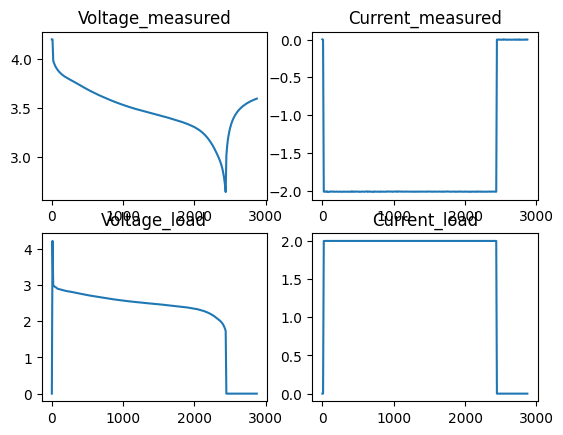

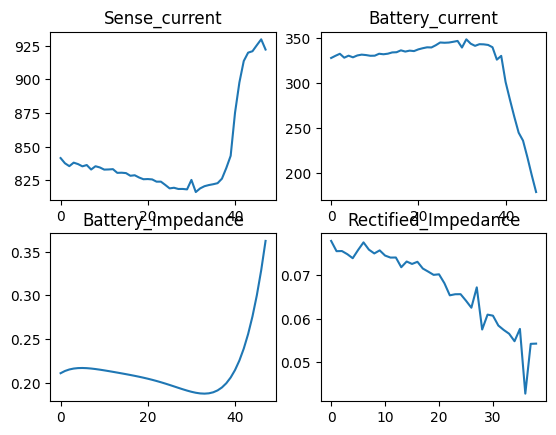

In [7]:
index = 501
# index=1
data_dir = "NASA/data/"
plot_cycle(data_dir, index)

## Analysis of Capacity Degradations

In [8]:
battery_ids = list(nasa.capacities.keys())

In [9]:
def calculate_eol_cycle(capacities):
    eol = [i for i, cap in enumerate(capacities) if cap < 0.7*capacities[0]]
    return eol
    

### Plot example Battery Cells

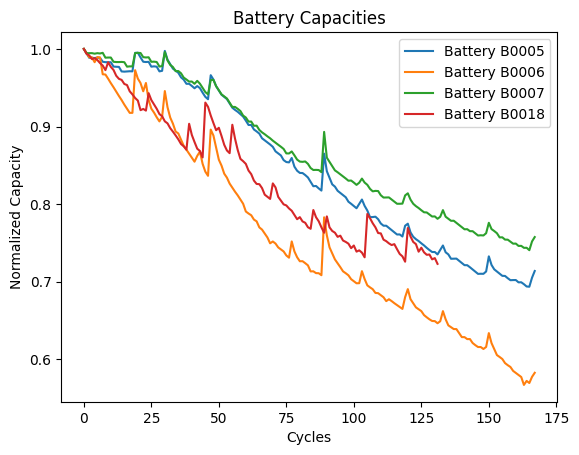

{'B0005': 161, 'B0006': 101}


In [10]:

start_index = 0
stop_index = 4
i = start_index
selected_ids = battery_ids[start_index:stop_index]
EOLs = {}

fig, ax = plt.subplots()
for bat_id in selected_ids:
    eol = calculate_eol_cycle(nasa.capacities[bat_id])
    if len(eol)> 0:
        EOLs[bat_id] = eol[0]
    ax.plot(nasa.capacities[bat_id], label=f"Battery {bat_id}")
    i += 1
plt.title("Battery Capacities")
plt.xlabel("Cycles")
plt.ylabel("Normalized Capacity")
plt.legend()
plt.show()
print(EOLs)

### Odd Battery Capacity Degradations

Text(0.5, 1.0, 'B0041_Battery_Capacity')

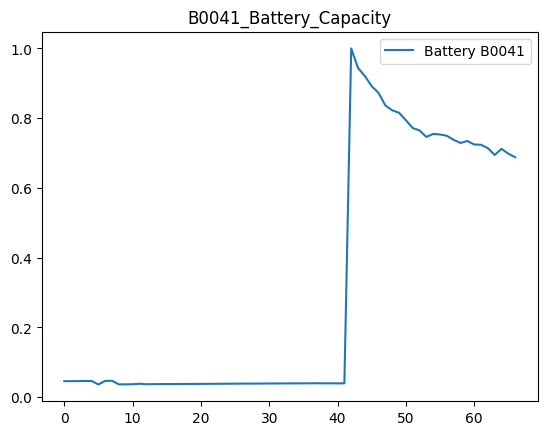

In [11]:
bat_id = "B0041"
plt.figure()
plt.plot(nasa.capacities[bat_id], label=f"Battery {bat_id}")
plt.legend()
plt.title(f"{bat_id}_Battery_Capacity")

Text(0.5, 1.0, 'B0042_Battery_Capacity')

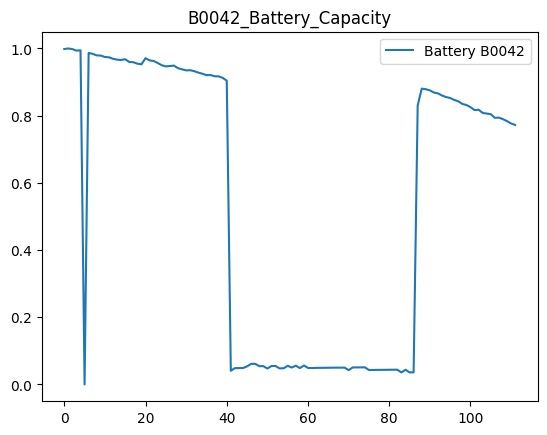

In [12]:
bat_id = "B0042"
plt.figure()
plt.plot(nasa.capacities[bat_id], label=f"Battery {bat_id}")
plt.legend()
plt.title(f"{bat_id}_Battery_Capacity")

### Corresponding Good Discharge Cycle 40

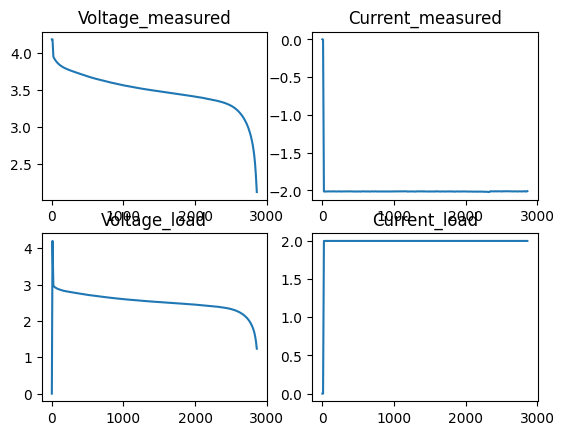

In [13]:
bat_id = "B0042"
b0042 = nasa.filter_rows(nasa.metadata, "battery_id", bat_id)

b0042_discharge = nasa.filter_rows(b0042, "type", "discharge")
b0042_discharge.head()
file = b0042_discharge["filename"].to_list()[40]
cycle_df = pd.read_csv(data_dir + file)
plot_data(cycle_df)

### Corresponding Odd Discharge Cycle 40

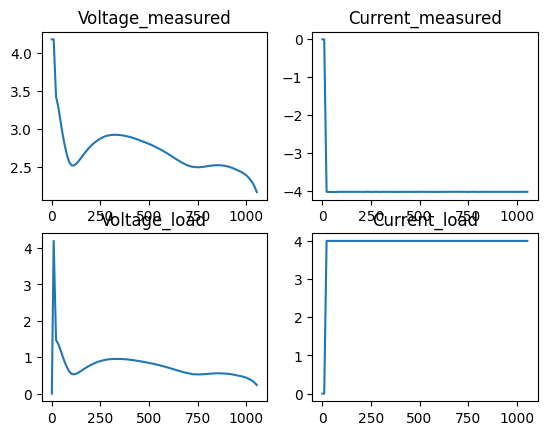

In [14]:
bat_id = "B0042"
b0042 = nasa.filter_rows(nasa.metadata, "battery_id", bat_id)

b0042_discharge = nasa.filter_rows(b0042, "type", "discharge")
b0042_discharge.head()
file = b0042_discharge["filename"].to_list()[41]
cycle_df = pd.read_csv(data_dir + file)
plot_data(cycle_df)


### Plot of all Battery Capacity Degradations

In [15]:
start_index = 0
stop_index = -1
i = start_index
selected_ids = battery_ids[start_index:stop_index]
for bat_id in selected_ids:
    plt.figure()
    plt.plot(nasa.capacities[bat_id], label=f"Battery {battery_ids[i]}")
    i += 1
    plt.legend()
    plt.title(f"{bat_id}_Battery_Capacity")



### Plot of some Resisitance Values

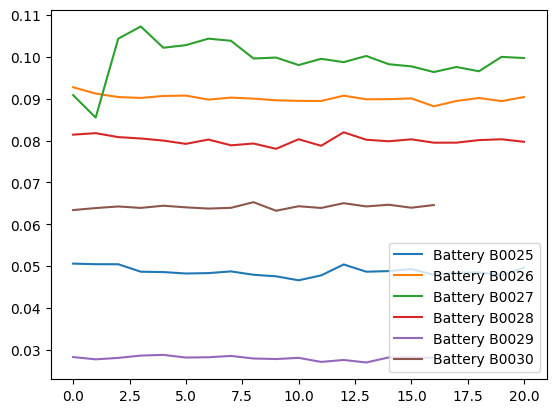

In [16]:
fig, ax = plt.subplots()
start_index = 4
stop_index = 10
selected_ids = battery_ids[start_index:stop_index]
for bat_id in selected_ids:
    ax.plot(nasa.Res[bat_id], label=f"Battery {bat_id}")
plt.legend()
plt.show()

In [17]:
start_index = 0
stop_index = -1
i = start_index
selected_ids = battery_ids[start_index:stop_index]
for bat_id in selected_ids[start_index:stop_index]:
    plt.figure()
    plt.plot(nasa.Res[bat_id], label=f"Battery {battery_ids[i]}")
    i += 1
    plt.legend()
    plt.title(f"{bat_id}_Re")

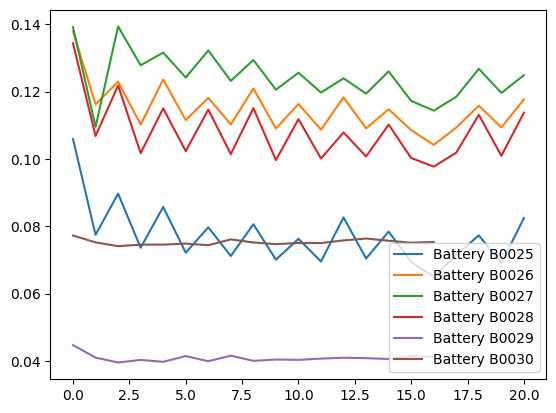

In [18]:
fig, ax = plt.subplots()
start_index = 4
stop_index = 10
i = start_index
selected_ids = battery_ids[start_index:stop_index]
for bat_id in selected_ids:
    ax.plot(nasa.Rcts[bat_id], label=f"Battery {bat_id}")
    i += 1
plt.legend()
plt.show()